In [63]:
dir_data = "C:/Users/ysp/Desktop/Deep Learning/dataset1"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

In [64]:
import glob, os
all_img_paths = glob.glob(os.path.join(dir_img, '*.png'))
all_img_paths[:5]

['C:/Users/ysp/Desktop/Deep Learning/dataset1/images_prepped_train\\0001TP_006690.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/images_prepped_train\\0001TP_006720.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/images_prepped_train\\0001TP_006750.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/images_prepped_train\\0001TP_006780.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/images_prepped_train\\0001TP_006810.png']

In [65]:
import glob, os
all_mask_paths = glob.glob(os.path.join(dir_seg, '*.png'))
all_mask_paths[:5]

['C:/Users/ysp/Desktop/Deep Learning/dataset1/annotations_prepped_train\\0001TP_006690.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/annotations_prepped_train\\0001TP_006720.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/annotations_prepped_train\\0001TP_006750.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/annotations_prepped_train\\0001TP_006780.png',
 'C:/Users/ysp/Desktop/Deep Learning/dataset1/annotations_prepped_train\\0001TP_006810.png']

In [66]:
all_img_paths[0].split('\\')[-1]

'0001TP_006690.png'

In [67]:
x = []
y = []
count=0

In [68]:
import cv2
import imageio
for i in range(len(all_img_paths)):
  img = cv2.imread(all_img_paths[i])
  img = cv2.resize(img,(224,224))
  mask_path = dir_seg+all_img_paths[i].split('\\')[-1]
  img_mask = imageio.imread(mask_path)   # Changed to skimage read
  img_mask = cv2.resize(img_mask,(224,224))
  x.append(img)
  y.append(img_mask)
  if(i%100==0):
    print(i)


0
100
200
300


In [69]:
import numpy as np
np.array(y).shape

(367, 224, 224)

In [70]:
np.array(x).shape

(367, 224, 224, 3)

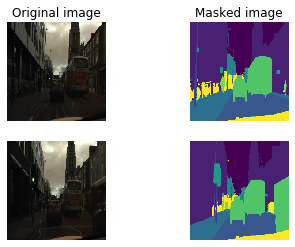

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(x[3])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(222)
plt.imshow(y[3])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')
plt.subplot(223)
plt.imshow(x[1])
plt.axis('off')
plt.grid('off')
plt.subplot(224)
plt.imshow(y[1])
plt.axis('off')
plt.grid('off')
plt.show()

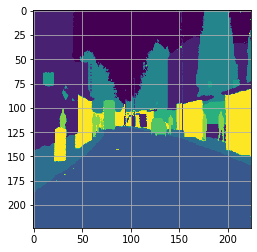

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_mask)
plt.grid('off')
plt.show()

In [73]:
set(np.array(y).flatten())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [74]:
np.array(y).shape

(367, 224, 224)

In [75]:
n_classes = len(set(np.array(y).flatten()))
n_classes

12

In [76]:
def getsegnum(img):
  seg_labels = np.zeros((  224 , 224  , 12 ))
  for c in range(12):
    seg_labels[: , : , c ] = (img == c ).astype(int)
  return seg_labels

In [77]:
y2 = []
for i in range(len(y)):
  y2.append(getsegnum(y[i]))

In [78]:
x = np.array(x)
y2 = np.array(y2)
print(x.shape, y2.shape)
print(np.unique(y2))

(367, 224, 224, 3) (367, 224, 224, 12)
[0. 1.]


In [79]:
x = x/255
print(np.max(x))

1.0


In [80]:
from keras.applications.vgg16 import VGG16
base_vgg16 = VGG16(input_shape =  (224,224,3), include_top = False, weights = 'imagenet')
base_vgg16.trainable = False

Using TensorFlow backend.


In [81]:
from keras.layers import Input, Conv2D, MaxPooling2D,UpSampling2D, Dropout, merge, concatenate,BatchNormalization 
from keras.optimizers import Adam
from keras.models import Model

In [82]:
conv1 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block1_conv2').output).output
conv2 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block2_conv2').output).output
conv3 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block3_conv3').output).output
conv4 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block4_conv3').output).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(inputs=base_vgg16.input,outputs=base_vgg16.get_layer('block5_conv3').output).output
drop5 = Dropout(0.5)(conv5)

In [83]:
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv7))
merge8 = concatenate([conv2,up8],axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(UpSampling2D(size =(2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(12, 1, activation = 'softmax')(conv9)

In [84]:
model = Model(input = base_vgg16.input, output = conv10)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

C:\Users\ysp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  """Entry point for launching an IPython kernel.


In [85]:
for layer in model.layers[:18]:
  layer.trainable = False

In [86]:
model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss='categorical_crossentropy', metrics = ['accuracy'])

In [87]:
np.max(x)

1.0

In [88]:
history = model.fit(x,y2,epochs=10,batch_size=1,validation_split=0.1)

Train on 330 samples, validate on 37 samples
Epoch 1/10
330/330 [==============================] - 338s 1s/step - loss: 0.9179 - accuracy: 0.7330 - val_loss: 2.4604 - val_accuracy: 0.2816
Epoch 2/10
330/330 [==============================] - 340s 1s/step - loss: 0.6783 - accuracy: 0.8079 - val_loss: 0.7772 - val_accuracy: 0.7867
Epoch 3/10
330/330 [==============================] - 340s 1s/step - loss: 0.5740 - accuracy: 0.8380 - val_loss: 0.7319 - val_accuracy: 0.7833
Epoch 4/10
330/330 [==============================] - 338s 1s/step - loss: 0.5342 - accuracy: 0.8467 - val_loss: 0.6675 - val_accuracy: 0.8180
Epoch 5/10
330/330 [==============================] - 338s 1s/step - loss: 0.4860 - accuracy: 0.8606 - val_loss: 0.6689 - val_accuracy: 0.8151
Epoch 6/10
330/330 [==============================] - 337s 1s/step - loss: 0.4410 - accuracy: 0.8742 - val_loss: 0.6512 - val_accuracy: 0.8220
Epoch 7/10
330/330 [==============================] - 338s 1s/step - loss: 0.4127 - accuracy: 0.8

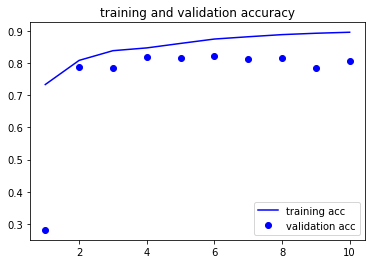

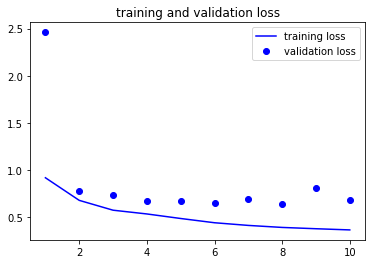

In [89]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [90]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred, axis=-1)
y_testi = np.argmax(y2[-2:], axis=-1)
#np.mean(y_predi == y_testi)
y_predi.shape

(2, 224, 224)

In [91]:
np.mean(y_predi == y_testi)

0.813835299744898

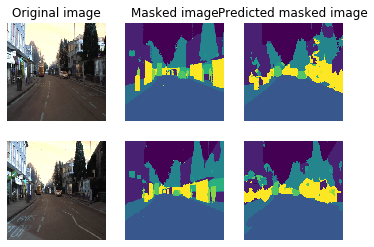

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y[-1])
plt.axis('off')
plt.title('Masked image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_predi[-1])
plt.axis('off')
plt.title('Predicted masked image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(235)
plt.imshow(y[-2])
plt.axis('off')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_predi[-2])
plt.axis('off')
plt.grid('off')
plt.show()

In [93]:
from keras.utils import plot_model

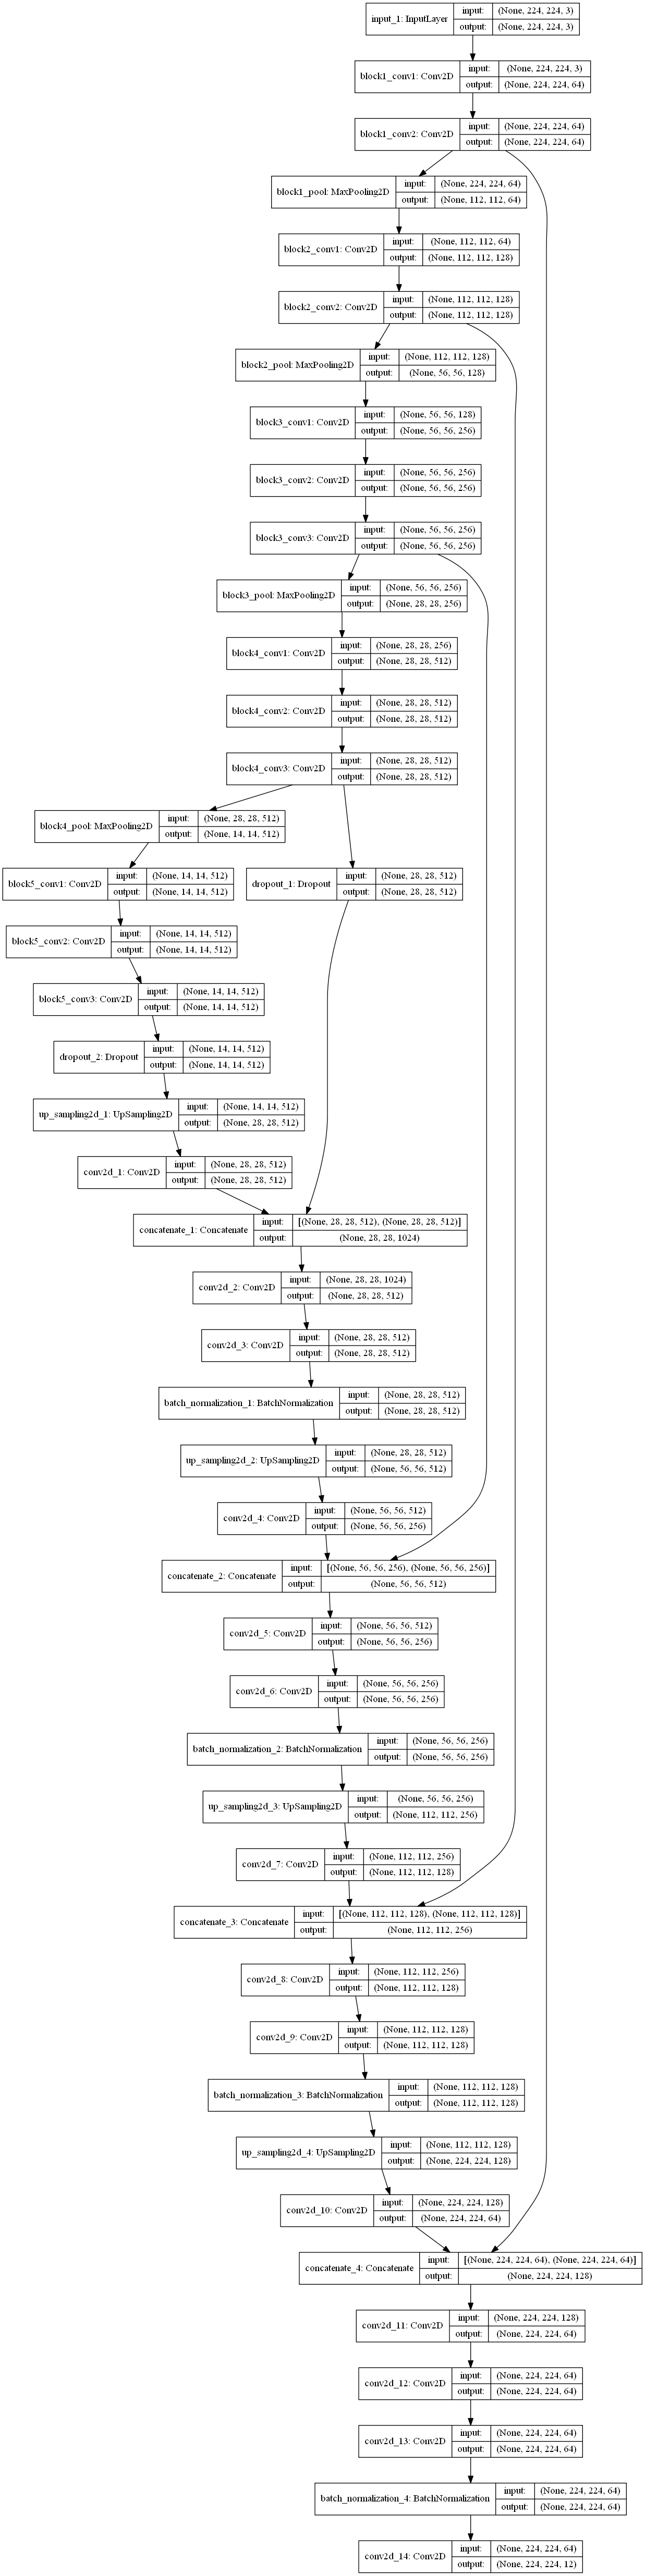

In [94]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')